# Classifying endangered birds from the Prek Toal Reserve

The Prek Toal flooded forest is the last breeding site for a series of large waterbirds throughout Southeast Asia. It is an internationally important refuge for the Spot-billed Pelican, Milky Stork and Painted Stork, Greater and Lesser Adjutant and Black-headed Ibis, all of which are globally threatened species. These species nest in dense colonies throughout the reserve between October and June. In addition, the sanctuary is also home to the Grey-headed Fish-eagle and the very rare and enigmatic Masked finfoot.

The colonies, discovered in 1994, were then seriously threatened by a massive collection of eggs and chicks. In 1996, an estimated 26,000 eggs and 3,000 chicks were collected. They were resold in the floating villages as a delicacy and a change of the daily fish. Since 2001, a team of forest rangers, consisting of villagers including former poachers, has been set up by the Wildlife Conservation Society (WCS) with the support of [Osmose](http://osmosetonlesap.net/wp/index.php/en/home/), a Cambodian NGO. This conservation team ensures the protection of colonies throughout the reproductive cycle and since then the numbers have increased dramatically.

**Goal:** build and deploy an image classifier capable of distinguishing between the following threatened bird species:

- Greater Adjutant
- Lesser Adjutant
- Painted Stork
- Milky Stork
- Asian Openbill
- Spot-billed Pelican
- Oriental Darter
- Black-head Ibis
- Grey-headed Fish Eagle

In [3]:
from fastai.vision import *

## Get a list of Google Images URLs

### Search and scroll

Go to [Google Images](http://images.google.com) and search for the images you are interested in. The more specific you are in your Google Search, the better the results and the less manual pruning you will have to do.

Scroll down until you've seen all the images you want to download, or until you see a button that says 'Show more results'. All the images you scrolled past are now available to download. To get more, click on the button, and continue scrolling. The maximum number of images Google Images shows is 700.

It is a good idea to put things you want to exclude into the search query, for instance if you are searching for the Eurasian wolf, "canis lupus lupus", it might be a good idea to exclude other variants:

    "canis lupus lupus" -dog -arctos -familiaris -baileyi -occidentalis

You can also limit your results to show only photos by clicking on Tools and selecting Photos from the Type dropdown.

### Download into file

Now you must run some Javascript code in your browser which will save the URLs of all the images you want for you dataset.

In Google Chrome press <kbd>Ctrl</kbd><kbd>Shift</kbd><kbd>j</kbd> on Windows/Linux and <kbd>Cmd</kbd><kbd>Opt</kbd><kbd>j</kbd> on macOS, and a small window the javascript 'Console' will appear. In Firefox press <kbd>Ctrl</kbd><kbd>Shift</kbd><kbd>k</kbd> on Windows/Linux or <kbd>Cmd</kbd><kbd>Opt</kbd><kbd>k</kbd> on macOS. That is where you will paste the JavaScript commands.

You will need to get the urls of each of the images. Before running the following commands, you may want to disable ad blocking extensions (uBlock, AdBlockPlus etc.) in Chrome. Otherwise the window.open() command doesn't work. Then you can run the following commands:

```javascript
urls=Array.from(document.querySelectorAll('.rg_i')).map(el=> el.hasAttribute('data-src')?el.getAttribute('data-src'):el.getAttribute('data-iurl'));
window.open('data:text/csv;charset=utf-8,' + escape(urls.join('\n')));
```

### Create directory and upload urls file into your server

Choose an appropriate name for your labeled images. You can run these steps multiple times to create different labels.

In [ ]:
folder = 'asian_openbill'
file = 'asian_openbill.csv'

In [ ]:
folder = 'black_ibis'
file = 'black_ibis.csv'

In [ ]:
folder = 'fish_eagle'
file = 'fish_eagle.csv'

In [ ]:
folder = 'greater_adj'
file = 'greater_adj.csv'

In [ ]:
folder = 'lesser_adj'
file = 'lesser_adj.csv'

In [ ]:
folder = 'milky_stork'
file = 'milky_stork.csv'

In [ ]:
folder = 'oriental_darter'
file = 'oriental_darter.csv'

In [ ]:
folder = 'painted_stork'
file = 'painted_stork.csv'

In [ ]:
folder = 'sb_pelican'
file = 'sb_pelican.csv'

You will need to run this cell once per each category.

In [ ]:
path = Path('data/osmose-birds')
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)

In [ ]:
path.ls()

Finally, upload your urls file.

## Download images

Now you will need to download your images from their respective urls.

fast.ai has a function that allows you to do just that. You just have to specify the urls filename as well as the destination folder and this function will download and save all images that can be opened. If they have some problem in being opened, they will not be saved.

Let's download our images! Notice you can choose a maximum number of images to be downloaded. In this case we will not download all the urls.

You will need to run this line once for every category.

In [ ]:
classes = ['asian_openbill','black_ibis','fish_eagle' ,'greater_adj','lesser_adj','milky_stork','oriental_darter','painted_stork','sb_pelican']

In [ ]:
download_images(path/file, dest, max_pics=200)

In [ ]:
# If you have problems download, try with `max_workers=0` to see exceptions:
download_images(path/file, dest, max_pics=20, max_workers=0)

Then we can remove any images that can't be opened:

In [ ]:
for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_size=500)

## View data

In [ ]:
path = Path('data/osmose-birds')

In [ ]:
np.random.seed(2)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [ ]:
data.classes

In [ ]:
data.show_batch(rows=3, figsize=(7,8))

In [ ]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

## Train model

In [ ]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [ ]:
learn.fit_one_cycle(4)

In [ ]:
learn.save('stage-1')

In [ ]:
learn.unfreeze()

In [ ]:
learn.lr_find()

In [ ]:
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(2, max_lr=slice(3e-5,3e-4))

In [ ]:
learn.save('stage-2')

## Interpretation

In [ ]:
learn.load('stage-2');

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

In [ ]:
interp.plot_confusion_matrix()

## Cleaning Up

Some of our top losses aren't due to bad performance by our model. There are images in our data set that shouldn't be.

Using the `ImageCleaner` widget from `fastai.widgets` we can prune our top losses, removing photos that don't belong.

In [ ]:
from fastai.widgets import *

First we need to get the file paths from our top_losses. We can do this with `.from_toplosses`. We then feed the top losses indexes and corresponding dataset to `ImageCleaner`.

The widget will not delete images directly from disk but will create a new csv file `cleaned.csv` from where you can create a new ImageDataBunch with the corrected labels to continue training your model.

In order to clean the entire set of images, we need to create a new dataset without the split.

In [ ]:
db = (ImageList.from_folder(path)
                   .split_none()
                   .label_from_folder()
                   .transform(get_transforms(), size=224)
                   .databunch()
     )

In [ ]:
# If you already cleaned your data using indexes from `from_toplosses`,
# run this cell instead of the one before to proceed with removing duplicates.
# Otherwise all the results of the previous step would be overwritten by
# the new run of `ImageCleaner`.

db = (ImageList.from_csv(path, 'cleaned.csv', folder='.')
                   .split_none()
                   .label_from_df()
                   .transform(get_transforms(), size=224)
                   .databunch()
     )

Then we create a new learner to use our new databunch with all the images.

In [ ]:
learn_cln = cnn_learner(db, models.resnet34, metrics=error_rate)

learn_cln.load('stage-2');

In [ ]:
ds, idxs = DatasetFormatter().from_toplosses(learn_cln)

In [ ]:
ImageCleaner(ds, idxs, path)

Flag photos for deletion by clicking 'Delete'. Then click 'Next Batch' to delete flagged photos and keep the rest in that row. `ImageCleaner` will show you a new row of images until there are no more to show. In this case, the widget will show you images until there are none left from `top_losses.ImageCleaner(ds, idxs)`

You can also find duplicates in your dataset and delete them! To do this, you need to run `.from_similars` to get the potential duplicates' ids and then run `ImageCleaner` with `duplicates=True`. The API works in a similar way as with misclassified images: just choose the ones you want to delete and click 'Next Batch' until there are no more images left.

Make sure to recreate the databunch and `learn_cln` from the `cleaned.csv` file. Otherwise the file would be overwritten from scratch, losing all the results from cleaning the data from toplosses.

In [ ]:
ds, idxs = DatasetFormatter().from_similars(learn_cln)

In [ ]:
ImageCleaner(ds, idxs, path, duplicates=True)

Remember to recreate your ImageDataBunch from your `cleaned.csv` to include the changes you made in your data!

## Training the model with clean data

In [5]:
path = Path('data/osmose-birds')

In [3]:
# If you already cleaned your data, run this cell
np.random.seed(2)
data = ImageDataBunch.from_csv(path, folder=".", valid_pct=0.2, csv_labels='cleaned.csv',
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

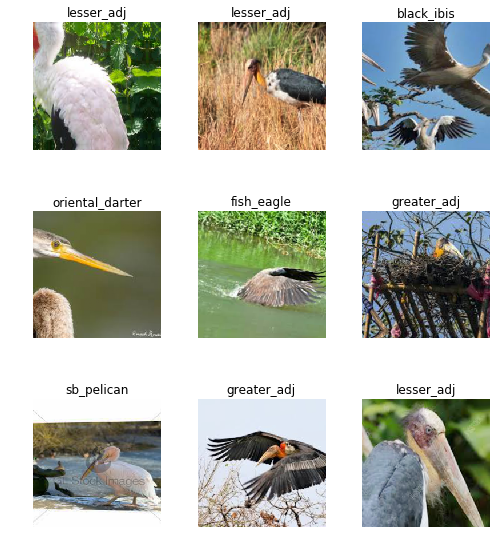

In [4]:
data.show_batch(rows=3, figsize=(7,8))

In [5]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['asian_openbill',
  'black_ibis',
  'fish_eagle',
  'greater_adj',
  'lesser_adj',
  'milky_stork',
  'oriental_darter',
  'painted_stork',
  'sb_pelican'],
 9,
 1328,
 332)

In [6]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [7]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,2.534383,0.846319,0.271084,00:06
1,1.670858,0.696423,0.228916,00:05
2,1.265461,0.677670,0.207831,00:05
3,1.014619,0.651372,0.207831,00:05


In [8]:
learn.save('cleaned-stage-1')

In [9]:
learn.unfreeze()

In [10]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


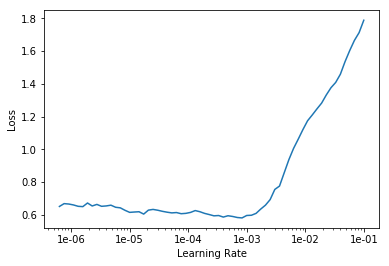

In [11]:
learn.recorder.plot()

In [12]:
learn.fit_one_cycle(4, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.624623,0.646269,0.201807,00:06
1,0.602284,0.613635,0.201807,00:06
2,0.554734,0.598609,0.192771,00:06
3,0.548920,0.594939,0.195783,00:06


In [13]:
learn.save('cleaned-stage-2')

## Visualizing Results

In [14]:
interp = ClassificationInterpretation.from_learner(learn)

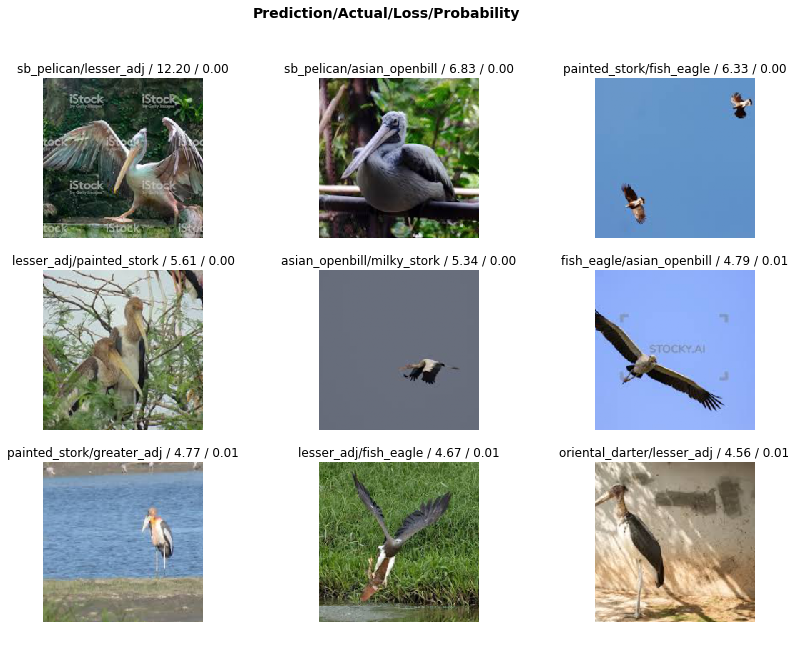

In [15]:
interp.plot_top_losses(9, figsize=(14,10))

Errors are mostly due to mislabelled images.

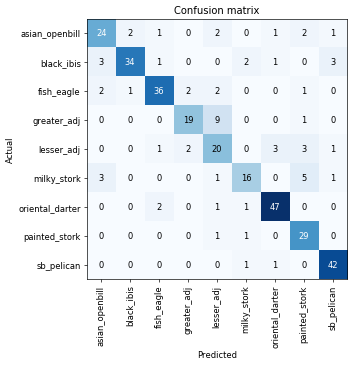

In [16]:
interp.plot_confusion_matrix(figsize=(6,6), dpi=60)

In [17]:
interp.most_confused(min_val=3)

[('greater_adj', 'lesser_adj', 9),
 ('milky_stork', 'painted_stork', 5),
 ('black_ibis', 'asian_openbill', 3),
 ('black_ibis', 'sb_pelican', 3),
 ('lesser_adj', 'oriental_darter', 3),
 ('lesser_adj', 'painted_stork', 3),
 ('milky_stork', 'asian_openbill', 3)]

## Training: resnet101

In [6]:
np.random.seed(2)
data = ImageDataBunch.from_csv(path, folder=".", valid_pct=0.2, csv_labels='cleaned.csv', 
                               ds_tfms=get_transforms(), size=332, bs=32).normalize(imagenet_stats)

In [7]:
learn = cnn_learner(data, models.resnet101, metrics=error_rate)

In [8]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.693059,0.792147,0.204819,00:37
1,1.162908,0.705692,0.207831,00:33
2,0.855518,0.512628,0.153614,00:37
3,0.579527,0.485696,0.156627,00:33


In [9]:
learn.save('resnet101-stage-1')

In [10]:
learn.unfreeze()

In [11]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


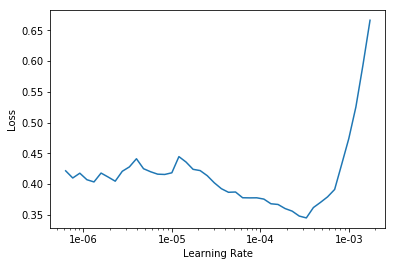

In [12]:
learn.recorder.plot()

In [13]:
learn.fit_one_cycle(4, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.400943,0.458886,0.138554,00:43
1,0.339096,0.443757,0.138554,00:43
2,0.307659,0.452219,0.138554,00:49
3,0.256456,0.456305,0.144578,00:49


In [14]:
learn.save('resnet101-stage-2')

We could train for a couple more epochs to get better accuracy, but let's try giving another shot to the resnet34 model.

## Improving the resnet34 model

In [15]:
np.random.seed(2)
data = ImageDataBunch.from_csv(path, folder=".", valid_pct=0.2, csv_labels='cleaned.csv',
        ds_tfms=get_transforms(), size=512, num_workers=4, bs=18).normalize(imagenet_stats)

In [16]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [17]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,2.476526,1.114621,0.352410,00:23
1,1.753853,0.900508,0.298193,00:22
2,1.237611,0.708967,0.237952,00:22
3,0.937694,0.669639,0.216867,00:21


In [18]:
learn.save('retry-stage-1')

In [19]:
learn.unfreeze()

In [20]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


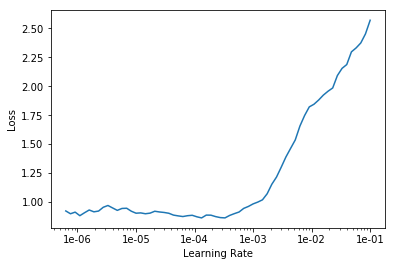

In [21]:
learn.recorder.plot()

In [22]:
learn.fit_one_cycle(4, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.823591,0.661815,0.216867,00:26
1,0.831529,0.595043,0.180723,00:28
2,0.693389,0.584269,0.189759,00:49
3,0.659543,0.577445,0.171687,00:46


In [23]:
learn.save('retry-stage-2')

In [24]:
learn.fit_one_cycle(10, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.650568,0.562805,0.177711,00:32
1,0.615646,0.537659,0.153614,00:31
2,0.612161,0.537075,0.159639,00:31
3,0.539887,0.520064,0.165663,00:32
4,0.488016,0.513137,0.159639,00:31
5,0.470767,0.509807,0.153614,00:31
6,0.431857,0.503668,0.174699,00:33
7,0.366925,0.493523,0.165663,00:31
8,0.370042,0.473070,0.156627,00:31
9,0.359012,0.485664,0.147590,00:31


In [25]:
learn.save('final-model')

## Putting your model in production

We can export the content of our `Learner` object for production:

In [26]:
learn.export('osmose_classification.pkl')

We can now deploy our model.